# Basic regression: Predict fuel efficiency

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This tutorial uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. To do this, you will provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

This example uses the Keras API. (Visit the Keras [tutorials](https://www.tensorflow.org/tutorials/keras) and [guides](https://www.tensorflow.org/guide/keras) to learn more.)

In [45]:
# Use seaborn for pairplot.
# !pip install -q seaborn

In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [47]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.2


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download and import the dataset using pandas:

In [48]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [49]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

The dataset contains a few unknown values:

In [50]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [51]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Drop those rows to keep this initial tutorial simple:

In [52]:
dataset = dataset.dropna()

The `"Origin"` column is categorical, not numeric. So the next step is to one-hot encode the values in the column with [pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html).

Note: You can set up the `tf.keras.Model` to do this kind of transformation for you but that's beyond the scope of this tutorial. Check out the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) or [Load CSV data](../load_data/csv.ipynb) tutorials for examples.

In [53]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [54]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [55]:
train_dataset = dataset.sample(frac=0.8, random_state=2)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Review the joint distribution of a few pairs of columns from the training set.

The top row suggests that the fuel efficiency (MPG) is a function of all the other parameters. The other rows indicate they are functions of each other.

CPU times: user 3.49 s, sys: 88.8 ms, total: 3.58 s
Wall time: 3.6 s


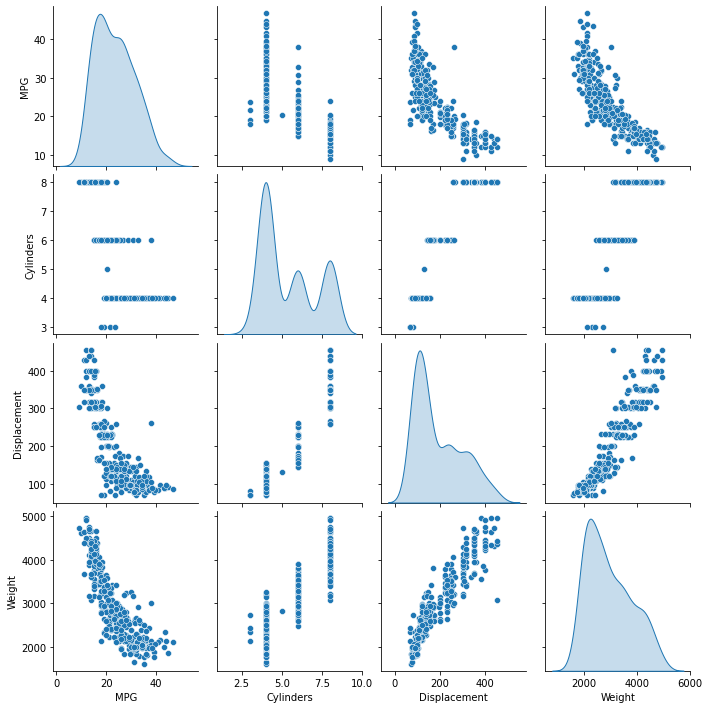

In [56]:
%%time
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [57]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.599682,7.855689,9.0,17.5,23.0,29.00,46.6
Cylinders,314.0,5.429936,1.694719,3.0,4.0,4.0,7.50,8.0
Displacement,314.0,193.116242,105.042544,70.0,105.0,146.0,260.00,455.0
Horsepower,314.0,104.815287,39.381208,46.0,75.0,92.0,124.25,230.0
Weight,314.0,2961.292994,840.948956,1613.0,2220.0,2764.5,3573.00,4955.0
Acceleration,314.0,15.439172,2.810051,8.0,13.5,15.4,17.00,24.8
Model Year,314.0,76.133758,3.674618,70.0,73.0,76.0,79.00,82.0
Europe,314.0,0.162420,0.369425,0.0,0.0,0.0,0.00,1.0
Japan,314.0,0.200637,0.401116,0.0,0.0,0.0,0.00,1.0
USA,314.0,0.636943,0.481649,0.0,0.0,1.0,1.00,1.0


### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [58]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [59]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.599682,7.855689
Cylinders,5.429936,1.694719
Displacement,193.116242,105.042544
Horsepower,104.815287,39.381208
Weight,2961.292994,840.948956
Acceleration,15.439172,2.810051
Model Year,76.133758,3.674618
Europe,0.162420,0.369425
Japan,0.200637,0.401116
USA,0.636943,0.481649


It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [60]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [61]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [62]:
print(normalizer.mean.numpy())

[[   5.43   193.116  104.815 2961.293   15.439   76.134    0.162    0.201
     0.637]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [63]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    91.    70.  1955.    20.5   71.     0.     0.     1. ]]

Normalized: [[-0.85 -0.97 -0.89 -1.2   1.8  -1.4  -0.44 -0.5   0.75]]


## Linear regression

Before building a deep neural network model, start with linear regression using one and several variables.

### Linear regression using Scipy

Let us use the package *scipy* first to build a simple linear regression model. The API for the scipy library is [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html). We will call *stats* modules and the function *linregress* is the function that we need.

In [64]:
import scipy

In [65]:
x = train_features['Horsepower']
y = train_labels

In [66]:
slope, intercept, r, p, se = scipy.stats.linregress(x, y)

In [67]:
slope, intercept, r, p, se

(-0.15383009605996553,
 39.723427138616515,
 -0.7711627565219936,
 3.809948006403222e-63,
 0.007189696482234588)

In [68]:
print('Linear model: MPG = ' + str(np.round(intercept, 3)) + str(np.round(slope, 3)) + '*Horsepower')

Linear model: MPG = 39.723-0.154*Horsepower


In [69]:
print('Pearson correlation = ' + str(np.round(r, 3)))

Pearson correlation = -0.771


In [70]:
print('p-value = ' + str(np.round(p, 3)))

p-value = 0.0


In [71]:
print('standard error for the coefficient = ' + str(np.round(se, 3)))

standard error for the coefficient = 0.007


### Linear regression with one variable

Begin with a single-variable linear regression to predict `'MPG'` from `'Horsepower'`.

Training a model with `tf.keras` typically starts by defining the model architecture. Use a `tf.keras.Sequential` model, which [represents a sequence of steps](https://www.tensorflow.org/guide/keras/sequential_model).

There are two steps in your single-variable linear regression model:

- Normalize the `'Horsepower'` input features using the `tf.keras.layers.Normalization` preprocessing layer.
- Apply a linear transformation ($y = mx+b$) to produce 1 output using a linear layer (`tf.keras.layers.Dense`).

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the `'Horsepower'` features. Then, instantiate the `tf.keras.layers.Normalization` and fit its state to the `horsepower` data:

In [72]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

Build the Keras Sequential model:

This "sequential" term is referring to the Sequential API (as contrast to Functional API). This is NOT the sequential model that we use in RNN (Recurrent Neural Network, a model for Natural Language Processing).

In [73]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `'MPG'` from `'Horsepower'`.

Run the untrained model on the first 10 'Horsepower' values. The output won't be good, but notice that it has the expected shape of `(10, 1)`:

In [74]:
horsepower_model.predict(horsepower[:10])

array([[-1.   ],
       [-0.225],
       [-0.426],
       [-1.489],
       [-0.828],
       [-1.632],
       [ 0.149],
       [-0.943],
       [ 0.149],
       [ 1.298]], dtype=float32)

Once the model is built, configure the training procedure using the Keras `Model.compile` method. The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`mean_absolute_error`) and how (using the `tf.keras.optimizers.Adam`).

Mean square error

$$\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i))^2 = \frac{1}{n} \sum_{i=1}^n (y_i - f(\text{Horsepower}))^2$$

Mean absolute error

$$\frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i| = \frac{1}{n} \sum_{i=1}^n |y_i - f(\text{Horsepower})|$$

In [75]:
horsepower_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Use Keras `Model.fit` to execute the training for 100 epochs:

In [80]:
%%time
history = horsepower_model.fit(
    train_features['Horsepower'], # X (Horsepower)
    train_labels, # Y (MPG)
    # idea: y = f(x)
    epochs=100, # how many rounds you want to train your neural networks
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
    
    )

CPU times: user 4.87 s, sys: 155 ms, total: 5.02 s
Wall time: 6.66 s


Visualize the model's training progress using the stats stored in the `history` object:

In [81]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.808009,4.088981,95
96,3.807744,4.085258,96
97,3.808622,4.084408,97
98,3.805547,4.073556,98
99,3.809757,4.066654,99


In [82]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

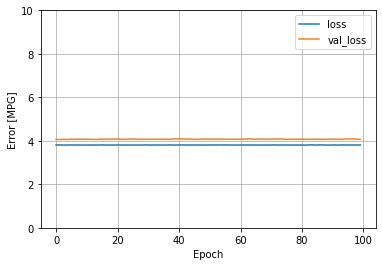

In [83]:
plot_loss(history)

Collect the results on the test set for later:

In [84]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0)

Since this is a single variable regression, it's easy to view the model's predictions as a function of the input:

In [85]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [86]:
def plot_horsepower(x, y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

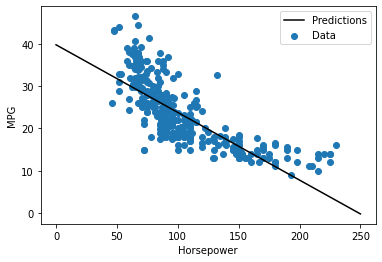

In [87]:
plot_horsepower(x, y)

### Linear regression with multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

Create a two-step Keras Sequential model again with the first layer being `normalizer` (`tf.keras.layers.Normalization(axis=-1)`) you defined earlier and adapted to the whole dataset:

In [88]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call `Model.predict` on a batch of inputs, it produces `units=1` outputs for each example:

In [89]:
linear_model.predict(train_features[:10])

array([[ 1.699],
       [ 0.558],
       [-0.667],
       [ 1.095],
       [ 0.316],
       [ 1.425],
       [-1.103],
       [ 0.975],
       [-0.225],
       [ 0.289]], dtype=float32)

When you call the model, its weight matrices will be built—check that the `kernel` weights (the $m$ in $y=mx+b$) have a shape of `(9, 1)`:

In [90]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[ 0.598],
       [-0.598],
       [-0.63 ],
       [ 0.1  ],
       [ 0.185],
       [-0.735],
       [ 0.481],
       [ 0.212],
       [ 0.187]], dtype=float32)>

Configure the model with Keras `Model.compile` and train with `Model.fit` for 100 epochs:

In [91]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [92]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.75 s, sys: 195 ms, total: 3.94 s
Wall time: 5.51 s


Using all the inputs in this regression model achieves a much lower training and validation error than the `horsepower_model`, which had one input:

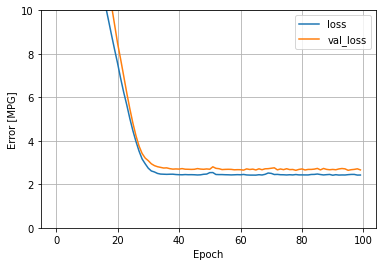

In [93]:
plot_loss(history)

Collect the results on the test set for later:

In [94]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [95]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### Regression using a DNN and a single input

Create a DNN model with only `'Horsepower'` as input and `horsepower_normalizer` (defined earlier) as the normalization layer:

In [96]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models:

In [97]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model with Keras `Model.fit`:

In [98]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.2 s, sys: 208 ms, total: 4.41 s
Wall time: 5.6 s


This model does slightly better than the linear single-input `horsepower_model`:

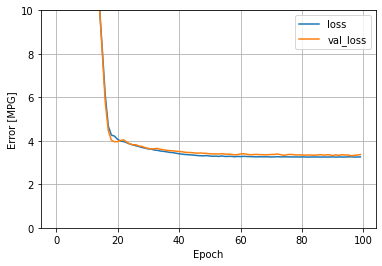

In [99]:
plot_loss(history)

If you plot the predictions as a function of `'Horsepower'`, you should notice how this model takes advantage of the nonlinearity provided by the hidden layers:

In [100]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

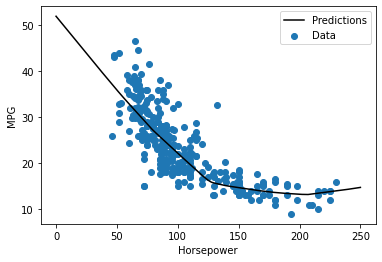

In [101]:
plot_horsepower(x, y)

Collect the results on the test set for later:

In [102]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

In [103]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 9)                19        
 ion)                                                            
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [104]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 4.38 s, sys: 223 ms, total: 4.61 s
Wall time: 4.17 s


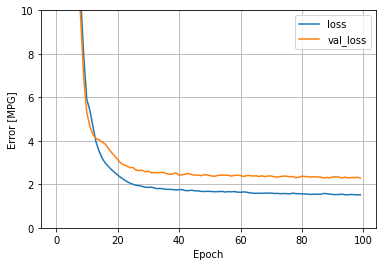

In [105]:
plot_loss(history)

Collect the results on the test set:

In [106]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have been trained, you can review their test set performance:

In [107]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.617558
linear_model,2.400713
dnn_horsepower_model,3.294869
dnn_model,1.899014


These results match the validation error observed during training.

### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

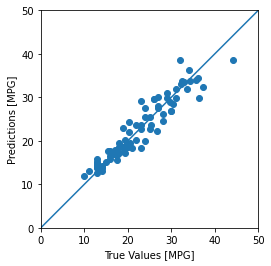

In [108]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It appears that the model predicts reasonably well.

Now, check the error distribution:

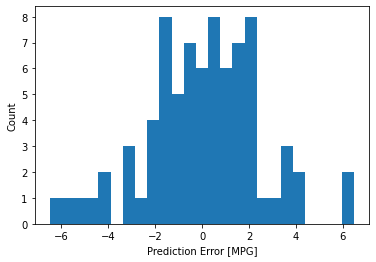

In [109]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model, save it for later use with `Model.save`:

In [110]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


If you reload the model, it gives identical output:

In [111]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [112]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.617558
linear_model,2.400713
dnn_horsepower_model,3.294869
dnn_model,1.899014
reloaded,1.899014


In [113]:
a = np.arange(1000)
len(a)

1000

(array([333., 333., 334.]),
 array([  0., 333., 666., 999.]),
 <a list of 3 Patch objects>)

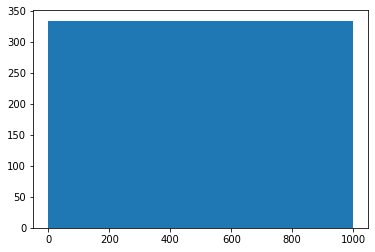

In [114]:
plt.hist(a, bins=3)

In [115]:
a.mean(), a.std()

(499.5, 288.6749902572095)

In [116]:
(a - a.mean())/a.std()

array([-1.73 , -1.727, -1.723, -1.72 , -1.716, -1.713, -1.71 , -1.706,
       -1.703, -1.699, -1.696, -1.692, -1.689, -1.685, -1.682, -1.678,
       -1.675, -1.671, -1.668, -1.665, -1.661, -1.658, -1.654, -1.651,
       -1.647, -1.644, -1.64 , -1.637, -1.633, -1.63 , -1.626, -1.623,
       -1.619, -1.616, -1.613, -1.609, -1.606, -1.602, -1.599, -1.595,
       -1.592, -1.588, -1.585, -1.581, -1.578, -1.574, -1.571, -1.568,
       -1.564, -1.561, -1.557, -1.554, -1.55 , -1.547, -1.543, -1.54 ,
       -1.536, -1.533, -1.529, -1.526, -1.522, -1.519, -1.516, -1.512,
       -1.509, -1.505, -1.502, -1.498, -1.495, -1.491, -1.488, -1.484,
       -1.481, -1.477, -1.474, -1.471, -1.467, -1.464, -1.46 , -1.457,
       -1.453, -1.45 , -1.446, -1.443, -1.439, -1.436, -1.432, -1.429,
       -1.425, -1.422, -1.419, -1.415, -1.412, -1.408, -1.405, -1.401,
       -1.398, -1.394, -1.391, -1.387, -1.384, -1.38 , -1.377, -1.374,
       -1.37 , -1.367, -1.363, -1.36 , -1.356, -1.353, -1.349, -1.346,
      

## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.